In [1]:
#import the reqired libraries
import random
random.seed(0)
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten 

from PIL import Image
from numpy import asarray

%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

from google.colab.patches import cv2_imshow
# Load the Drive helper and mount
from google.colab import drive
from sklearn.model_selection import train_test_split
from zipfile import ZipFile

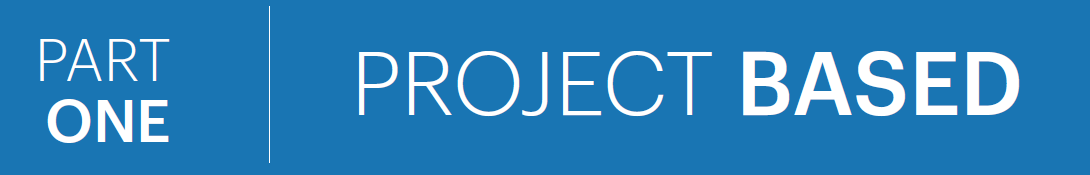


• DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the
movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision
and multimedia experts who need to detect faces from screen shots from the movie scene.

• DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.

• PROJECT OBJECTIVE: Face detection from training images.

Steps and tasks: 

1. Import the dataset.
2. Create features (images) and labels (mask) using that data.
3. Mask detection model:
● Design a face mask detection model.
Hint: Use U-net along with pre-trained transfer learning models
● Design your own Dice Coefficient and Loss function.
● Train, tune and test the model.
● Evaluate the model using testing data.
4. Use the “Prediction image” as an input to your designed model and display the output of the image.

In [2]:
# This will prompt for authorization.
drive.mount('/content/drive/')
!ls "/content/drive/MyDrive/Colab Notebooks/Adv_CV2"


Mounted at /content/drive/
'Part 1Test Data - Prediction Image.jpeg'
'Part 1- Train data - images.npy'
'Part 2- Test Image - Benedict Cumberbatch9.jpg'
'Part 2 - Test Image - Dwayne Johnson4.jpg'
'Part 3 - Aligned Face Dataset from Pinterest.zip'
'Part 3 - vgg_face_weights.h5'
 pins
 PINS


In [3]:
cd "/content/drive/MyDrive/Colab Notebooks/Adv_CV2"

/content/drive/MyDrive/Colab Notebooks/Adv_CV2


In [4]:
# Loading the images file
data = np.load('Part 1- Train data - images.npy', allow_pickle=True)

In [5]:
print('size:',data.size)
print('shape', data.shape)

size: 818
shape (409, 2)


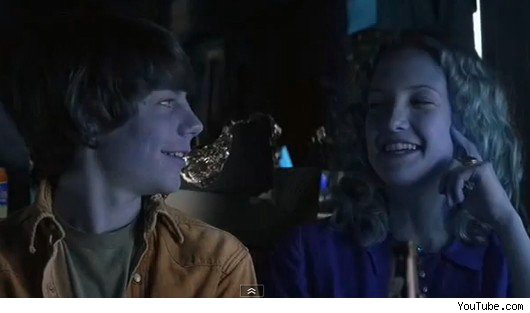

In [6]:
cv2_imshow(data[200][0])

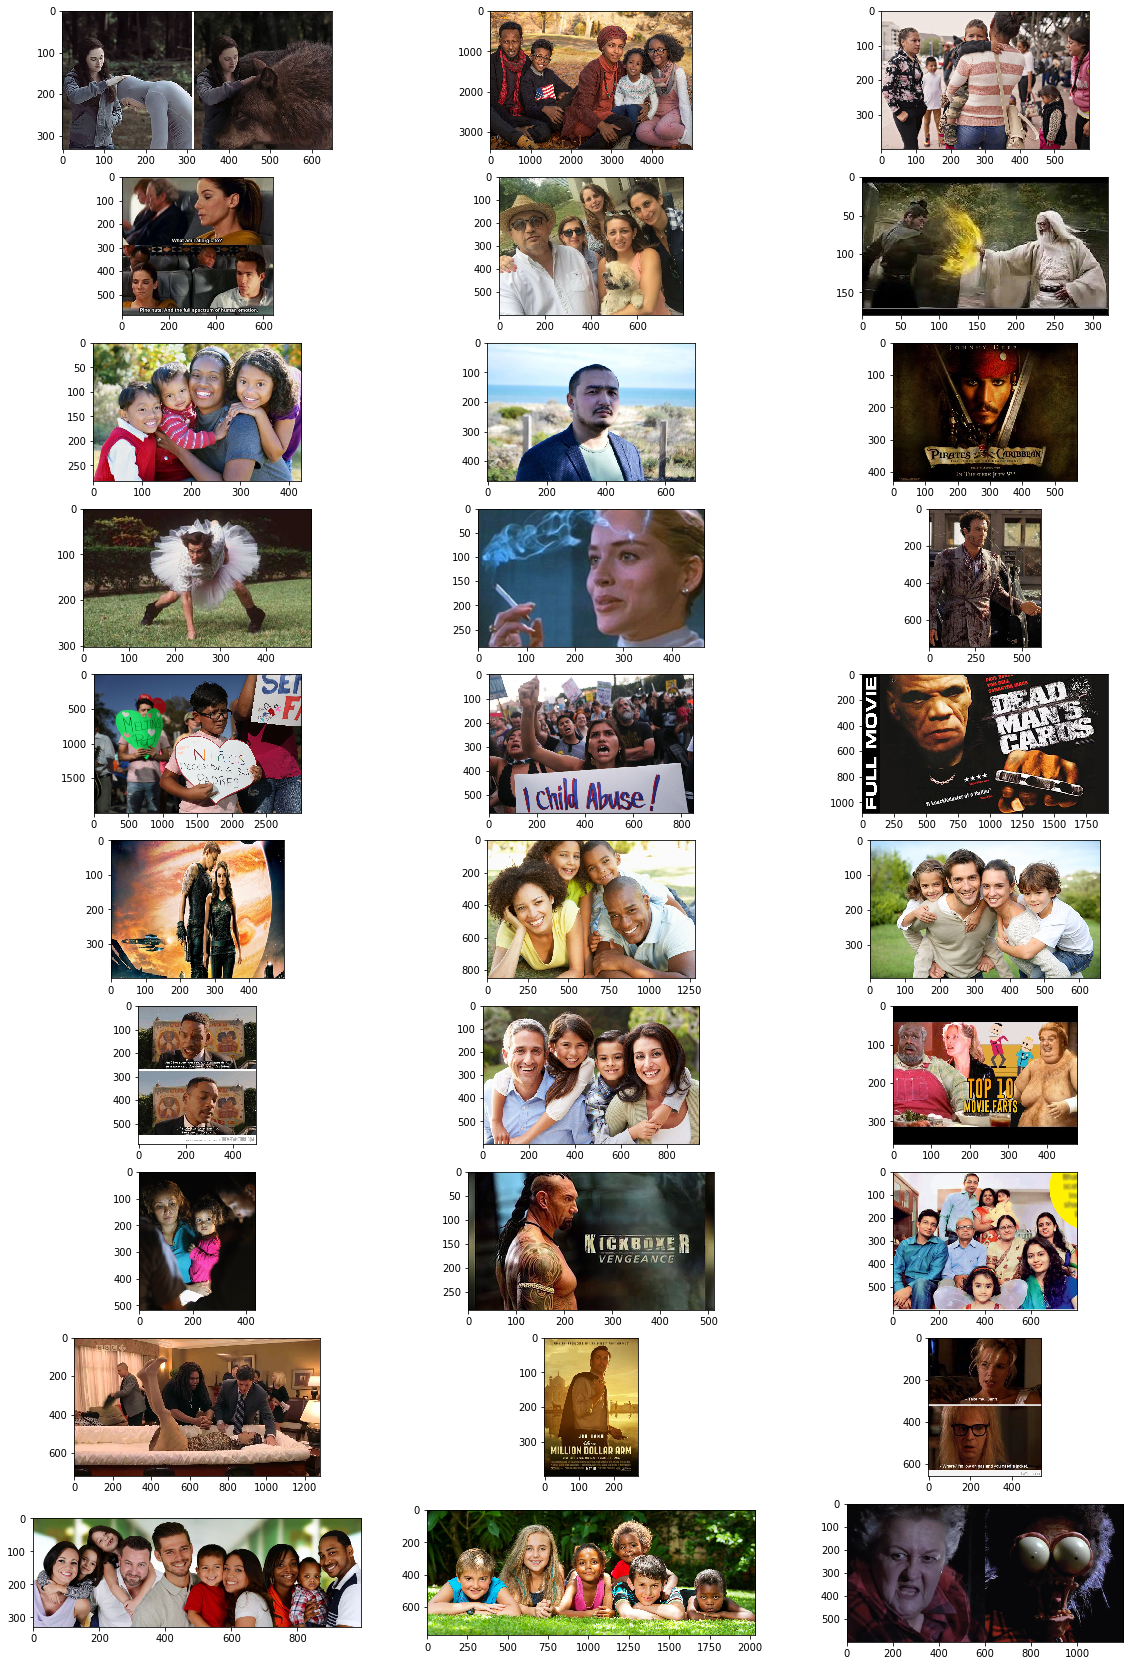

In [7]:
fi,axis = plt.subplots(10,3,figsize=(20,30))
row = 0
col = 0
index = 0
for i in range(30):
  axis[row][col].imshow(data[index][0], interpolation='nearest')
  index = index + 12
  col = col + 1
  if col > 2:
    row = row + 1
    col = 0
plt.show()


In [8]:
#Declare a variable IMAGE_SIZE = 224 as we will be taking Input shape as 224 * 224
IMAGE_SIZE = 224

In [9]:
masks = np.zeros((int(data.shape[0]), IMAGE_SIZE, IMAGE_SIZE))
X = np.zeros((int(data.shape[0]),IMAGE_SIZE, IMAGE_SIZE, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  image = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
 
  #only taking first 3 channel of each image
  try:
    image = image[:,:,:3]
  except:
    print(f"Number {index} is Grayscale image, converting to RGB to make it standard in data")
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(image, dtype=np.float32)) # Convert to float32 array

  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_SIZE)
    x2 = int(i['points'][1]['x'] * IMAGE_SIZE)
    y1 = int(i['points'][0]['y'] * IMAGE_SIZE)
    y2 = int(i['points'][1]['y'] * IMAGE_SIZE)

    masks[index][y1:y2, x1:x2] = 1
print(f"Shape of X is '{X.shape}' and the shape of mask dataset is '{masks.shape}' ")


Number 272 is Grayscale image, converting to RGB to make it standard in data
Shape of X is '(409, 224, 224, 3)' and the shape of mask dataset is '(409, 224, 224)' 


In [10]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


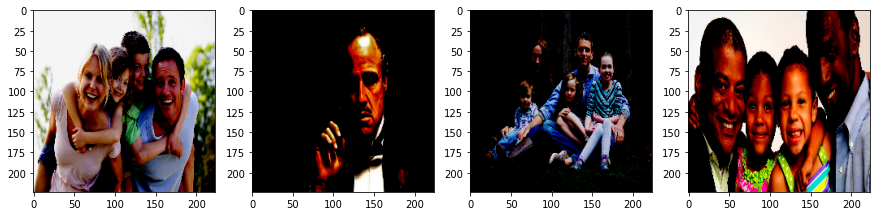

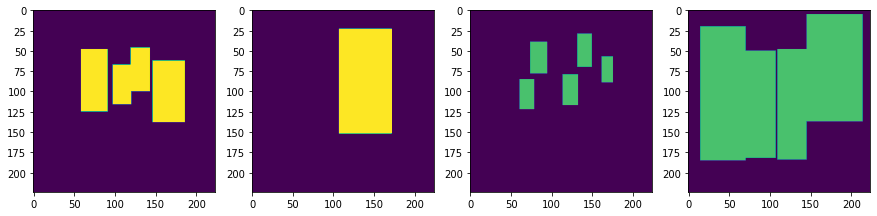

In [11]:
#view a train image
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0], cmap='gray')

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[30])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[30])
imgplot.set_clim(0.0, 1.4)

In [12]:
def create_model(trainable=True):
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")

    ALPHA = 0.35 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

    # Do not include classification (top) layer
    model = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=ALPHA)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = model.get_layer("block_13_expand_relu").output

    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = model.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [13]:
model = create_model()
model.summary()

2031616/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 16) 0           bn_Conv1[0][0]                   
_______________________________

In [14]:
smooth = 1e-15
def dice_coefficient(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [15]:
#Define loss function
def loss(y_true, y_pred):
    # return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())
    return 1.0 - dice_coefficient(y_true, y_pred)

Compile the model

Define optimizer

Define metrics

Define loss

In [16]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient, Recall(), Precision()])

#### Training the Model

In [17]:
EPOCHS = 32
BATCH = 10
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [18]:
train_steps = len(X_train)//BATCH
valid_steps = len(X_val)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_val) % BATCH != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/32
33/33 [==============================] - 90s 3s/step - loss: 0.7529 - dice_coefficient: 0.2480 - recall: 0.4629 - precision: 0.2672 - val_loss: 0.7339 - val_dice_coefficient: 0.2696 - val_recall: 0.9667 - val_precision: 0.1941
Epoch 2/32
33/33 [==============================] - 82s 2s/step - loss: 0.6064 - dice_coefficient: 0.3949 - recall: 0.8592 - precision: 0.4220 - val_loss: 0.6802 - val_dice_coefficient: 0.3243 - val_recall: 0.9768 - val_precision: 0.2317
Epoch 3/32
33/33 [==============================] - 82s 2s/step - loss: 0.5489 - dice_coefficient: 0.4516 - recall: 0.8810 - precision: 0.4861 - val_loss: 0.6484 - val_dice_coefficient: 0.3561 - val_recall: 0.9634 - val_precision: 0.2991
Epoch 4/32
33/33 [==============================] - 82s 2s/step - loss: 0.5172 - dice_coefficient: 0.4822 - recall: 0.8925 - precision: 0.5205 - val_loss: 0.6383 - val_dice_coefficient: 0.3663 - val_recall: 0.9635 - val_precision: 0.2955
Epoch 5/32
33/33 [==============================

In [19]:
#evaluate the model
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

2/2 [==============================] - 1s 379ms/step - loss: 0.4679 - dice_coefficient: 0.5345 - recall: 0.5707 - precision: 0.6793


[0.46791747212409973,
 0.5344786643981934,
 0.5707184076309204,
 0.6792795658111572]

The model has
* precision is 59.2%, 
* recall is 77.7%
* loss is 52% 
* dice coefficient is 47.3%.


#### Let's do predictions on the model we trained

In [20]:
filename = 'Part 1Test Data - Prediction Image.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (224, 224))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
print(feat_scaled)

[[[ 0.5686275   0.4666667   0.45098042]
  [ 0.56078434  0.45882356  0.4431373 ]
  [ 0.5764706   0.47450984  0.45882356]
  ...
  [-0.17647058 -0.5058824  -0.73333335]
  [-0.27058822 -0.49019605 -0.75686276]
  [-0.27843136 -0.47450978 -0.7411765 ]]

 [[ 0.6         0.49803925  0.48235297]
  [ 0.6         0.4901961   0.48235297]
  [ 0.6313726   0.5294118   0.5137255 ]
  ...
  [-0.20784312 -0.52156866 -0.7490196 ]
  [-0.16862744 -0.40392154 -0.6627451 ]
  [-0.19215685 -0.41176468 -0.6784314 ]]

 [[ 0.54509807  0.45098042  0.41960788]
  [ 0.47450984  0.3803922   0.34901965]
  [ 0.5372549   0.4431373   0.4039216 ]
  ...
  [-0.14509803 -0.42745095 -0.6627451 ]
  [-0.3098039  -0.5686275  -0.827451  ]
  [-0.34117645 -0.5921569  -0.8509804 ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [

In [21]:
y_pred = model.predict(np.array([feat_scaled]))
y_pred

array([[[[0.09446189],
         [0.04429492],
         [0.04057583],
         ...,
         [0.04639384],
         [0.0477547 ],
         [0.11959705]],

        [[0.03711373],
         [0.04169792],
         [0.03271258],
         ...,
         [0.03292519],
         [0.02366853],
         [0.04882821]],

        [[0.03670496],
         [0.0333401 ],
         [0.02920771],
         ...,
         [0.0318214 ],
         [0.02024457],
         [0.04246575]],

        ...,

        [[0.02657372],
         [0.02486521],
         [0.04255354],
         ...,
         [0.03902066],
         [0.02617252],
         [0.04464817]],

        [[0.0315139 ],
         [0.02876309],
         [0.03948918],
         ...,
         [0.03646418],
         [0.03054896],
         [0.07278934]],

        [[0.12925553],
         [0.0566991 ],
         [0.04988256],
         ...,
         [0.0585421 ],
         [0.06128988],
         [0.15886113]]]], dtype=float32)

In [22]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (224,224))

Viewing the predicted image 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


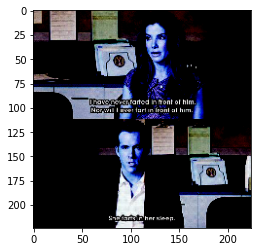

In [23]:
plt.imshow(feat_scaled)

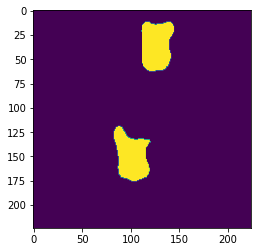

In [24]:
plt.imshow(pred_mask)

We are able to identify the face in the given pictures correctly.


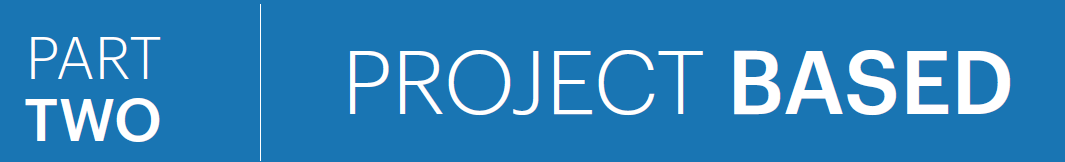

#### • DOMAIN: Face recognition
#### • CONTEXT: Company X intends to build a face identification model to recognise human faces.
#### • DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.
#### • PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library. Some data samples:
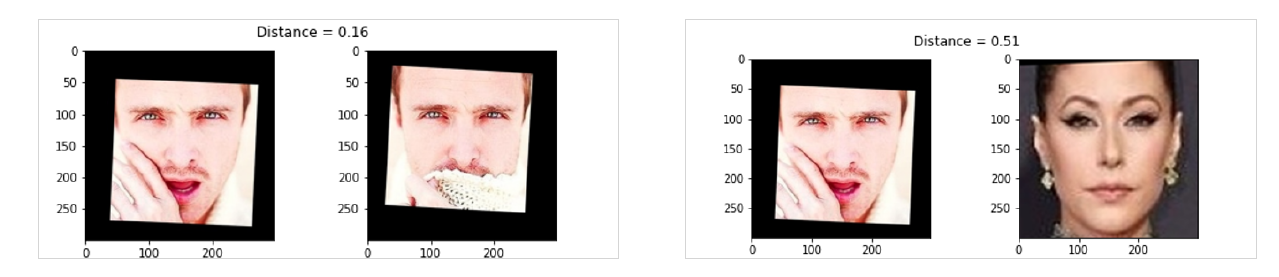
#### • TASK: In this problem, we use a pre-trained model trained on Face recognition to recognise similar faces. Here, we are particularly interested in recognising whether two given faces are of the same person or not. Below are the steps involved in the project.
##### • Load the dataset and create the metadata.
##### • Check some samples of metadata.
##### • Load the pre-trained model and weights.
##### • Generate Embedding vectors for each face in the dataset.
##### • Build distance metrics for identifying the distance between two given images.
##### • Use PCA for dimensionality reduction.
##### • Build an SVM classifier in order to map each image to its right person.
##### • Import the the test image. Display the image. Use the SVM trained model to predict the face.

In [25]:
# opening the zip file in READ mode
with ZipFile("Part 3 - Aligned Face Dataset from Pinterest.zip", 'r') as zip:
    zip.extractall()
    print('Done!')

Done!


In [26]:
directory = '/content/drive/MyDrive/Colab Notebooks/Adv_CV2/PINS/'

In [27]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        self.base = base #directory
        self.name = name #name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)
metadata = load_metadata('PINS')

In [28]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [29]:
print(metadata.shape)
metadata

(10770,)


array([PINS/pins_Aaron Paul/Aaron Paul0_262.jpg,
       PINS/pins_Aaron Paul/Aaron Paul101_248.jpg,
       PINS/pins_Aaron Paul/Aaron Paul101_247.jpg, ...,
       PINS/pins_zendaya/zendaya97.jpg, PINS/pins_zendaya/zendaya98.jpg,
       PINS/pins_zendaya/zendaya99.jpg], dtype=object)

Load few sample image

(299, 299, 3)


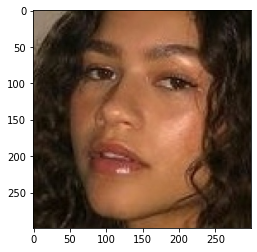

In [30]:
image = load_image("PINS/pins_zendaya/zendaya99.jpg")
print(image.shape)
plt.imshow(image)

(299, 299, 3)


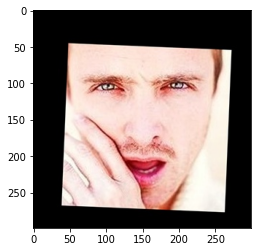

In [31]:
image2 = load_image("PINS/pins_Aaron Paul/Aaron Paul101_248.jpg")
print(image2.shape)
plt.imshow(image2)

#### VGG Face model

In [32]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [33]:
model = vgg_face()
model.load_weights("/content/drive/MyDrive/Colab Notebooks/Adv_CV2/Part 3 - vgg_face_weights.h5")

Get vgg_face_descriptor

In [34]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

Generate embeddings for each image in the dataset

In [35]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


Generate embeddings for all images 

In [36]:
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in enumerate(metadata):
  image_path = m.image_path()
  image = load_image(image_path)

  image = (image/255.).astype(np.float32)
  image = cv2.resize(image, dsize=(224,224))

  embedding_vector = vgg_face_descriptor.predict(np.expand_dims(image, axis=0))[0]
  embeddings[i] = embedding_vector

In [37]:
embeddings

array([[ 0.03170303, -0.0150513 , -0.01243402, ...,  0.0004314 ,
         0.0021908 , -0.00908097],
       [ 0.02801891, -0.00112629, -0.01265751, ..., -0.00904748,
        -0.005784  ,  0.02125827],
       [ 0.03497704, -0.00105059, -0.01248934, ..., -0.01053091,
         0.00179321,  0.02439156],
       ...,
       [ 0.00965872,  0.00372159, -0.01345865, ..., -0.01433404,
         0.01899944,  0.03899154],
       [ 0.0023093 ,  0.00094763, -0.00544814, ..., -0.01600495,
         0.01053975,  0.03683248],
       [ 0.017723  ,  0.01064051,  0.01995193, ..., -0.02618429,
         0.03288926,  0.04882648]])

In [38]:
#Function to calculate distance between given 2 pairs of images.
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

Plot images and get distance between the pairs given below

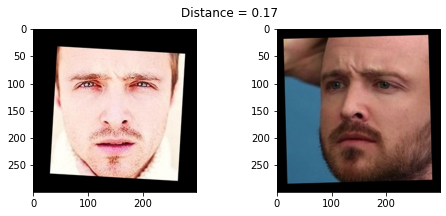

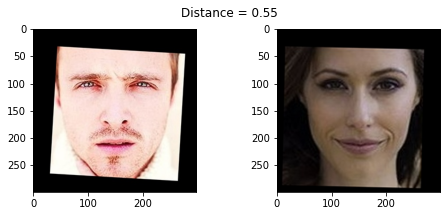

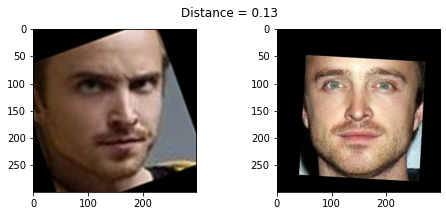

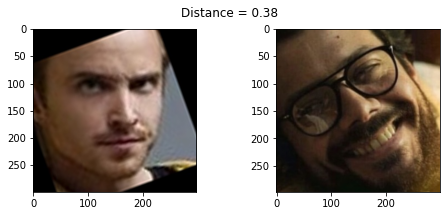

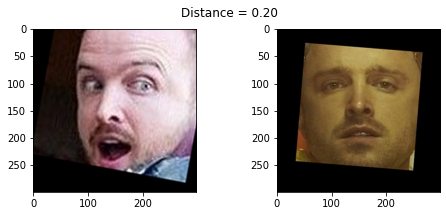

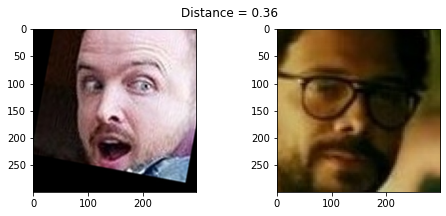

In [39]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

show_pair(30,31)
show_pair(30,100)

show_pair(70,72)
show_pair(70,115)

Create train and test sets

In [40]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

In [41]:
print(X_train[0])
print(y_train[0])

[ 0.02801891 -0.00112629 -0.01265751 ... -0.00904748 -0.005784
  0.02125827]
pins_Aaron Paul


In [42]:
np.unique(y_train)

array(['pins_Aaron Paul', 'pins_Alvaro Morte', 'pins_Amanda Crew',
       'pins_Amaury Nolasco', 'pins_Anna Gunn',
       'pins_Benedict Cumberbatch', 'pins_Betsy Brandt',
       'pins_Brenton Thwaites', 'pins_Brit Marling',
       'pins_Bryan Cranston', 'pins_Caity Lotz', 'pins_Cameron Monaghan',
       'pins_Chance Perdomo', 'pins_Chris Evans', 'pins_Chris Pratt',
       'pins_Cobie Smulders', 'pins_Danielle Panabaker',
       'pins_Dave Franco', 'pins_Dominic Purcell', 'pins_Dwayne Johnson',
       'pins_Emilia Clarke', 'pins_Emily Bett Rickards',
       'pins_Emma Stone', 'pins_Gwyneth Paltrow', 'pins_Henry Cavil',
       'pins_Jason Momoa', 'pins_Jeremy Renner', 'pins_Jesse Eisenberg',
       'pins_Jim Parsons', 'pins_Jon Bernthal', 'pins_Josh Radnor',
       'pins_Kit Harington', 'pins_Krysten Ritter',
       'pins_Kumail Nanjiani', 'pins_Maisie Williams',
       'pins_Mark Ruffalo', 'pins_Martin Starr', 'pins_Melissa benoit',
       'pins_Mike Colter', 'pins_Morena Baccarin', 'p

In [43]:
np.unique(y_test)

array(['pins_Aaron Paul', 'pins_Alvaro Morte', 'pins_Amanda Crew',
       'pins_Amaury Nolasco', 'pins_Anna Gunn',
       'pins_Benedict Cumberbatch', 'pins_Betsy Brandt',
       'pins_Brenton Thwaites', 'pins_Brit Marling',
       'pins_Bryan Cranston', 'pins_Caity Lotz', 'pins_Cameron Monaghan',
       'pins_Chance Perdomo', 'pins_Chris Evans', 'pins_Chris Pratt',
       'pins_Cobie Smulders', 'pins_Danielle Panabaker',
       'pins_Dave Franco', 'pins_Dominic Purcell', 'pins_Dwayne Johnson',
       'pins_Emilia Clarke', 'pins_Emily Bett Rickards',
       'pins_Emma Stone', 'pins_Gwyneth Paltrow', 'pins_Henry Cavil',
       'pins_Jason Momoa', 'pins_Jeremy Renner', 'pins_Jesse Eisenberg',
       'pins_Jim Parsons', 'pins_Jon Bernthal', 'pins_Josh Radnor',
       'pins_Kit Harington', 'pins_Krysten Ritter',
       'pins_Kumail Nanjiani', 'pins_Maisie Williams',
       'pins_Mark Ruffalo', 'pins_Martin Starr', 'pins_Melissa benoit',
       'pins_Mike Colter', 'pins_Morena Baccarin', 'p

Encode the Labels 

In [44]:
le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

Standardize the feature values

In [45]:
# Standarize features
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Reduce dimensions using PCA

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

Build a Classifier

In [47]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc = SVC()

svc.fit(X_train,y_train)

y_pred = svc.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9640768588137009


Test results 

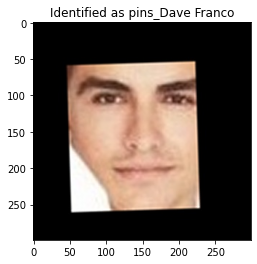

In [48]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx =200

example_image = load_image(metadata[test_idx][example_idx].image_path())

image = (example_image/255.).astype(np.float32)
image = cv2.resize(image, dsize=(224,224))

vector = vgg_face_descriptor.predict(np.expand_dims(image,axis=0))[0]
vector = np.reshape(vector,(1,-1))
scaled_vector = scaler.transform(vector)
pca_transformed = pca.transform(scaled_vector)

example_prediction = svc.predict(pca_transformed)
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

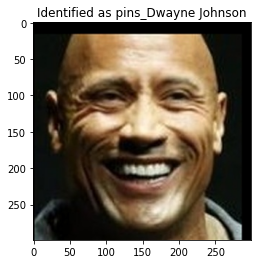

In [49]:
## predict first test image 

example_image = load_image("Part 2 - Test Image - Dwayne Johnson4.jpg")

image = (example_image/255.).astype(np.float32)
image = cv2.resize(image, dsize=(224,224))

vector = vgg_face_descriptor.predict(np.expand_dims(image,axis=0))[0]
vector = np.reshape(vector,(1,-1))
scaled_vector = scaler.transform(vector)
pca_transformed = pca.transform(scaled_vector)

example_prediction = svc.predict(pca_transformed)
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

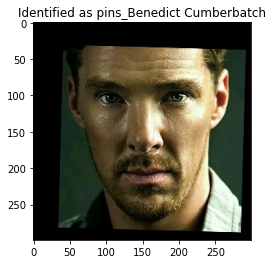

In [50]:
## predict second test image 

example_image = load_image("Part 2- Test Image - Benedict Cumberbatch9.jpg")

image = (example_image/255.).astype(np.float32)
image = cv2.resize(image, dsize=(224,224))

vector = vgg_face_descriptor.predict(np.expand_dims(image,axis=0))[0]
vector = np.reshape(vector,(1,-1))
scaled_vector = scaler.transform(vector)
pca_transformed = pca.transform(scaled_vector)

example_prediction = svc.predict(pca_transformed)
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

Able to predict the face correctly for both the test images.